https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [375]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from pandas import read_csv
from matplotlib import pyplot
from datetime import datetime

from math import sqrt
from numpy import concatenate, zeros
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN

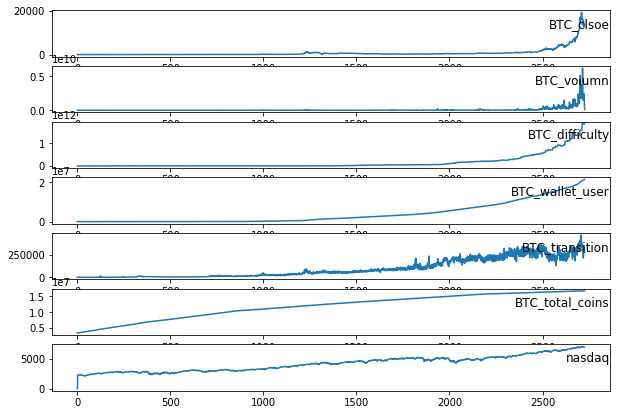

In [391]:
def plotData(fileName):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    columns = dataset.columns
    num_columns = len(columns)
    
    pyplot.figure(figsize=(10, num_columns)) # TODO - update figure size automatically
    for i in range(num_columns):
        pyplot.subplot(num_columns, 1, i+1)
        pyplot.plot(values[:, i])
        pyplot.title(columns[i], y=0.5, loc='right')
    pyplot.show()
        
plotData('result.csv')

In [408]:
# convert series to supervised learning
def seriesToSupervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prepareData(fileName, scaler, lookBack=1, trainPercent=0.7, encodeColumnIndex=[]):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    n_features = len(dataset.columns)
    print(dataset.columns)
    # integer encode direction
    for i in encodeColumnIndex:
        values[:,i] = LabelEncoder().fit_transform(values[:,i])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = seriesToSupervised(scaled, lookBack, 1)
    
    # split into train and test sets
    values = reframed.values
    trainSize = int(trainPercent * len(values))
    train = values[:trainSize, :]
    test = values[trainSize:, :]
    # split into input and outputs
    
    n_obs = lookBack * n_features
    trainX, trainY = train[:, :n_obs], train[:, -n_features]
    testX, testY = test[:, :n_obs], test[:, -n_features]
    # reshape input to be 3D [samples, timesteps, features]
    trainX = trainX.reshape((trainX.shape[0], lookBack, n_features))
    testX = testX.reshape((testX.shape[0], lookBack, n_features))
    
    return trainX, trainY, testX, testY

#trainX, trainY, testX, testY = prepareData('pollution.csv', scaler, lookBack=7, encodeColumnIndex=[4])
#print(trainX.shape, trainY.shape, testX.shape, testY.shape)

In [398]:
def trainLSTM(trainX, trainY, testX, testY, neurons=100, epochs=80, batchSize=128, verbose=1, loss='mae', optimizer='adam', plot=True):
    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    #model.add(LSTM(neurons, return_sequences=True))
    #model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    # fit network
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, validation_data=(testX, testY), verbose=verbose, shuffle=False)
    
    # plot history
    if (plot):
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()
    
    return model, history
    

#model, history = trainLSTM(trainX, trainY, testX, testY, 50)

In [336]:
def reverseScale(y, scaler):
    n_scaled=len(scaler.data_max_)
    inv = concatenate((y, zeros([y.shape[0], n_scaled-1])), axis=1) # don't case the 
    inv = scaler.inverse_transform(inv)
    return inv[:, 0]

def makePrediction(model, testX, testY, scaler, rmse=True, plot=True, printNumResults=20):
    # make a prediction
    yhat = model.predict(testX)
    shapedY = testY.reshape(len(testY), 1)
    
    if (rmse):
        rmse = sqrt(mean_squared_error(yhat, shapedY))
        print('Test RMSE: %.3f' % rmse)

    predictedY = reverseScale(yhat, scaler)
    y = reverseScale(shapedY, scaler)
    
    if (plot):
        pyplot.plot(y[-300:], label = 'y')
        pyplot.plot(predictedY[-300:], label = 'predictY')
        pyplot.legend()
        pyplot.show()
    
    if (printNumResults):
        print("Actual - ")
        print(y[-printNumResults:])
        print("Predict - ")
        print(predictedY[-printNumResults:])
        

    return predictedY, y

#predictedY, y = makePrediction(model, testX, testY)

In [426]:
def runLSTM(fileName, lookBack=3, trainPercent=0.9, encodeColumnIndex=[], epochs=80):
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainX, trainY, testX, testY = prepareData(fileName, scaler, lookBack, trainPercent=trainPercent, encodeColumnIndex = encodeColumnIndex)
    model, history = trainLSTM(trainX, trainY, testX, testY, epochs=epochs)
    predictedY, y = makePrediction(model, testX, testY, scaler)
    return predictedY, y, model, history

#runLSTM('bitcoin.csv', lookBack=7)

#runLSTM('pollution.csv', encodeColumnIndex=[4])

# PM2.5 PREDICTION

In [327]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('beijing_pm.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(method='pad', inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


# BITCOIN PREDICTION

In [328]:
# load data
dataset = read_csv('data/bitcoin_price.csv',parse_dates = ['Date'], index_col='Date', usecols=['Date', 'Close', 'Open'])
dataset = dataset.iloc[::-1]
dataset.index.name = 'Date'
# summarize first 5 rows
print(dataset.columns)
dataset = dataset[['Close', 'Open']]
print(dataset.head(5))
# save to file
dataset.to_csv('bitcoin.csv')

Index(['Open', 'Close'], dtype='object')
             Close    Open
Date                      
2013-04-28  134.21  135.30
2013-04-29  144.54  134.44
2013-04-30  139.00  144.00
2013-05-01  116.99  139.00
2013-05-02  105.21  116.38


In [329]:
predictedY, y, _, _ = runLSTM('bitcoin.csv', lookBack=3)

SyntaxError: unexpected EOF while parsing (<ipython-input-329-1fbe063317ec>, line 1)

# Use all info to refer bitcoin price

In [434]:
# load data
dataset = read_csv('data/result.csv',parse_dates = ['Date'], index_col='Date')
#dataset = dataset.iloc[::-1]
dataset.index.name = 'Date'
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
# summarize first 5 rows
columns = dataset.columns.tolist()
topColumn = 'BTC_clsoe'
columns.remove(topColumn)
dataset = dataset[[topColumn] + columns]
dataset = dataset.fillna(method='pad')
dataset = dataset.fillna(value=0)
dataset.to_csv('result.csv')
dataset.head(4)

,BTC_clsoe,BTC_open,BTC_high,BTC_volumn,DASH_open,DASH_high,DASH_clsoe,DASH_volumn,ETH_open,ETH_high,...,XRP_volumn,BTC_difficulty,BTC_wallet_user,BTC_transition,BTC_total_coins,gold,oil,dollar,nasdaq,trend
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.9902,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,181.543289,2.0,462.0,3436900.0,0.0,0.0,0.0000,0.00,0.0
2010-07-18,0.08584,0.04951,0.08585,5.0900,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,181.543289,2.0,427.0,3445850.0,0.0,0.0,0.0000,0.00,0.0
2010-07-19,0.08080,0.08584,0.09307,49.6600,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,181.543289,2.0,487.0,3454050.0,1181.0,0.0,76.6584,2198.23,0.0
2010-07-20,0.07474,0.08080,0.08181,20.5900,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,181.543289,2.0,627.0,3462950.0,1183.0,0.0,76.7410,2222.49,0.0


Index(['BTC_clsoe', 'BTC_open', 'BTC_high', 'BTC_volumn', 'BTC_difficulty',
       'BTC_wallet_user', 'BTC_transition', 'BTC_total_coins', 'gold', 'oil',
       'dollar', 'nasdaq', 'trend'],
      dtype='object')
Train on 2590 samples, validate on 137 samples
Epoch 1/300
2590/2590 [==============================] - 11s 4ms/step - loss: 0.0197 - val_loss: 0.3286
Epoch 2/300
2590/2590 [==============================] - 0s 49us/step - loss: 0.0199 - val_loss: 0.2438
Epoch 3/300
2590/2590 [==============================] - 0s 57us/step - loss: 0.0136 - val_loss: 0.2168
Epoch 4/300
2590/2590 [==============================] - 0s 83us/step - loss: 0.0460 - val_loss: 0.1443
Epoch 5/300
2590/2590 [==============================] - 0s 56us/step - loss: 0.0162 - val_loss: 0.2170
Epoch 6/300
2590/2590 [==============================] - 0s 52us/step - loss: 0.0104 - val_loss: 0.1640
Epoch 7/300
2590/2590 [==============================] - 0s 59us/step - loss: 0.0193 - val_loss: 0.1285
Epoch 8/300


2590/2590 [==============================] - 0s 51us/step - loss: 0.0087 - val_loss: 0.0281
Epoch 77/300
2590/2590 [==============================] - 0s 49us/step - loss: 0.0153 - val_loss: 0.0403
Epoch 78/300
2590/2590 [==============================] - 0s 51us/step - loss: 0.0083 - val_loss: 0.0635
Epoch 79/300
2590/2590 [==============================] - 0s 56us/step - loss: 0.0084 - val_loss: 0.0320
Epoch 80/300
2590/2590 [==============================] - 0s 44us/step - loss: 0.0037 - val_loss: 0.0374
Epoch 81/300
2590/2590 [==============================] - 0s 48us/step - loss: 0.0092 - val_loss: 0.0459
Epoch 82/300
2590/2590 [==============================] - 0s 58us/step - loss: 0.0033 - val_loss: 0.0319
Epoch 83/300
2590/2590 [==============================] - 0s 58us/step - loss: 0.0039 - val_loss: 0.0379
Epoch 84/300
2590/2590 [==============================] - 0s 48us/step - loss: 0.0060 - val_loss: 0.0292
Epoch 85/300
2590/2590 [==============================] - 0s 39us/st

2590/2590 [==============================] - 0s 56us/step - loss: 0.0049 - val_loss: 0.0283
Epoch 154/300
2590/2590 [==============================] - 0s 62us/step - loss: 0.0092 - val_loss: 0.0278
Epoch 155/300
2590/2590 [==============================] - 0s 53us/step - loss: 0.0024 - val_loss: 0.0282
Epoch 156/300
2590/2590 [==============================] - 0s 47us/step - loss: 0.0081 - val_loss: 0.0269
Epoch 157/300
2590/2590 [==============================] - 0s 43us/step - loss: 0.0022 - val_loss: 0.0278
Epoch 158/300
2590/2590 [==============================] - 0s 46us/step - loss: 0.0060 - val_loss: 0.0342
Epoch 159/300
2590/2590 [==============================] - 0s 68us/step - loss: 0.0030 - val_loss: 0.0277
Epoch 160/300
2590/2590 [==============================] - 0s 48us/step - loss: 0.0036 - val_loss: 0.0266
Epoch 161/300
2590/2590 [==============================] - 0s 49us/step - loss: 0.0058 - val_loss: 0.0265
Epoch 162/300
2590/2590 [==============================] - 0

2590/2590 [==============================] - 0s 41us/step - loss: 0.0025 - val_loss: 0.0332
Epoch 231/300
2590/2590 [==============================] - 0s 45us/step - loss: 0.0025 - val_loss: 0.0259
Epoch 232/300
2590/2590 [==============================] - 0s 47us/step - loss: 0.0066 - val_loss: 0.0300
Epoch 233/300
2590/2590 [==============================] - 0s 44us/step - loss: 0.0030 - val_loss: 0.0241
Epoch 234/300
2590/2590 [==============================] - 0s 48us/step - loss: 0.0035 - val_loss: 0.0266
Epoch 235/300
2590/2590 [==============================] - 0s 52us/step - loss: 0.0044 - val_loss: 0.0250
Epoch 236/300
2590/2590 [==============================] - 0s 45us/step - loss: 0.0050 - val_loss: 0.0283
Epoch 237/300
2590/2590 [==============================] - 0s 48us/step - loss: 0.0077 - val_loss: 0.0272
Epoch 238/300
2590/2590 [==============================] - 0s 57us/step - loss: 0.0046 - val_loss: 0.0343
Epoch 239/300
2590/2590 [==============================] - 0

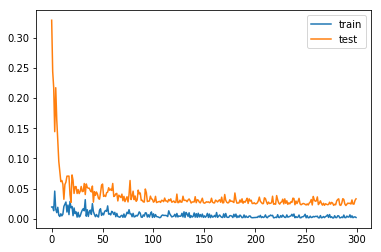

Test RMSE: 0.050


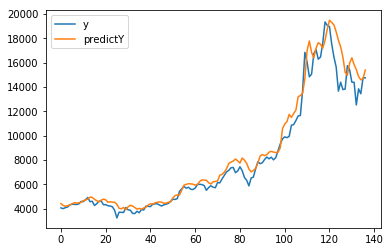

Actual - 
[ 17604.84910777  19345.4897812   19065.71035469  18972.32024802
  17523.69892582  16461.9710731   15632.12032071  13664.9701258
  14396.45985156  13789.94996186  13833.49019333  15756.5593631
  15416.63999187  14398.70028243  14392.57051891  12531.5196582
  13850.40008461  13444.87979046  14754.12970805  14755.82012064]
Predict - 
[ 17192.06211504  17824.57737657  18749.3668196   19489.37894606
  19306.39120681  19110.48668596  18527.27012825  17835.8763895
  17291.97633796  16458.80587354  15210.04413028  14975.58413486
  15960.32903011  16403.62301183  15849.73730339  15432.28380332
  14866.55136982  14594.70166184  14691.90615108  15399.1328061 ]


In [441]:
predictedY, y, model, _ = runLSTM('result.csv', lookBack=1, trainPercent=0.95, epochs=300)

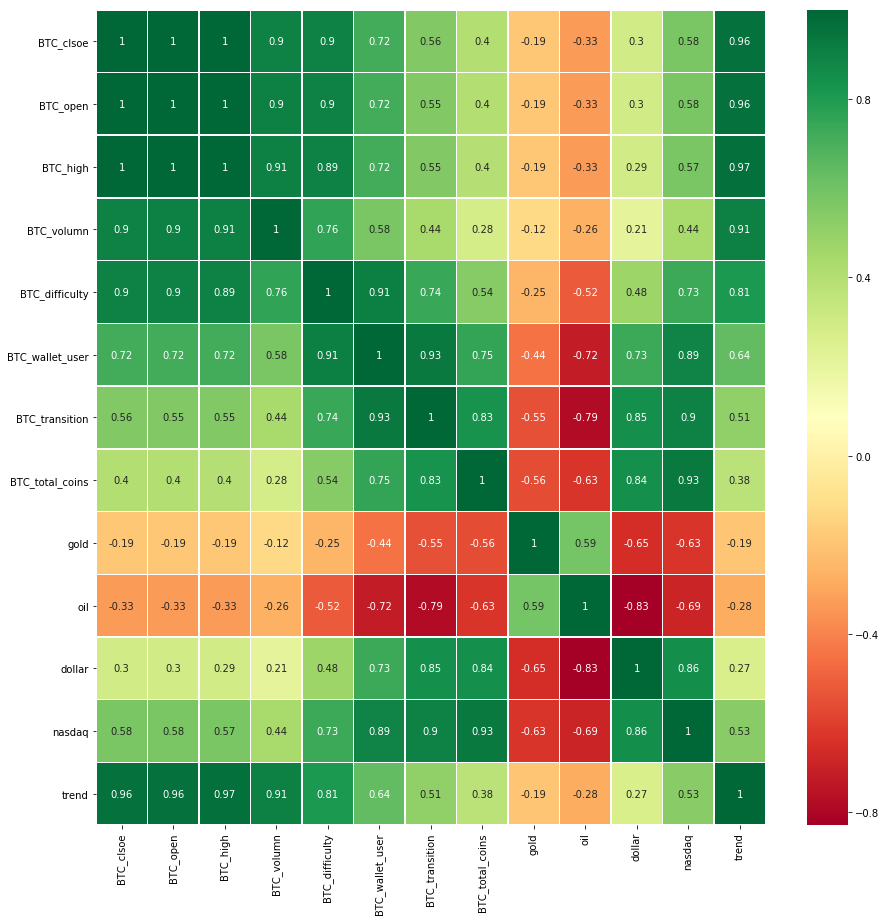

In [440]:
import seaborn as sns
fig, ax = pyplot.subplots(figsize=(15,15))
dataset = read_csv('result.csv',parse_dates = ['Date'], index_col='Date')
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=.5, ax=ax)
